<a href="https://colab.research.google.com/github/ptran1203/gan_project/blob/master/notebooks/Chestxray_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content

/content


In [2]:
%tensorflow_version 1.x
from google.colab import drive, output
drive.mount('/content/drive')

!rm -rf '/content/gan_project'
!git clone https://github.com/ptran1203/gan_project
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install image-classifiers
from classification_models.keras import Classifiers
## for Model definition/training
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from keras import applications
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from keras.regularizers import l2
import keras.backend as K
from keras_contrib.applications.resnet import ResNet, basic_block
from keras_contrib.applications.densenet import DenseNet
import keras.applications as k_apps
from keras.layers import (
    Input, Dense, Reshape,
    Flatten, Embedding, Dropout,
    BatchNormalization, Activation,
    Lambda,Layer, Add, Concatenate,
    Average,GlobalAveragePooling2D,
    MaxPooling2D, AveragePooling2D,
)
from keras.layers.convolutional import (
    UpSampling2D, Convolution2D,
    Conv2D, Conv2DTranspose
)
from keras.optimizers import Adam, SGD

from tensorflow.examples.tutorials.mnist import input_data
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import pickle

output.clear()

In [3]:
cd gan_project

/content/gan_project


In [4]:
from tensorflow.examples.tutorials.mnist import input_data
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image as iprocess
import keras
import datetime
from triplet_loss import *
from utils import *
from const import *
import metrics
from visualization import *
from data_augmentation.data_loader import load_gen, load_dataset
from data_augmentation.model import *

Require data augmentation


In [7]:
## Load dataset
# load data
dataset = 'multi_chest'
resolution = 64
large = False
train_classes = 5
[
    x_train, y_train, x_val, y_val,
    x_test, y_test , x_unseen, y_unseen
] = load_dataset(dataset, resolution, large, train_classes)

load data from /content/drive/My Drive/bagan/dataset/multi_chest/imgs_labels_64.pkl successfully

===== data loaded =====

TRAIN:  Counter({3: 690, 4: 688, 2: 685, 0: 683, 1: 674})


Total classes:  5
Test on 1080 samples
Train on fake data
load data from /content/drive/My Drive/bagan/dataset/multi_chest/imgs_train_gen_v1.pkl successfully


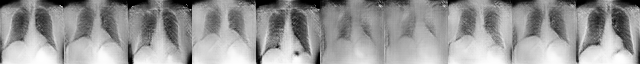

After aug:  8946
run experiments  1
Train on 8946 samples, validate on 500 samples
Epoch 1/30
8946/8946 [==============================] - 19s 2ms/step - loss: 1.5873 - main_out_loss: 1.4332 - l2_loss_loss: 15.3824 - main_out_accuracy: 0.4260 - l2_loss_accuracy: 0.0000e+00 - val_loss: 1.6558 - val_main_out_loss: 1.5457 - val_l2_loss_loss: 10.9871 - val_main_out_accuracy: 0.3200 - val_l2_loss_accuracy: 0.0000e+00
Epoch 2/30
8946/8946 [==============================] - 18s 2ms/step - loss: 1.3089 - main_out_loss: 1.1875 - l2_loss_loss: 12.1286 - main_out_accuracy: 0.5381 - l2_loss_accuracy: 0.0000e+00 - val_loss: 1.5886 - val_main_out_loss: 1.5057 - val_l2_loss_loss: 8.2380 - val_main_out_accuracy: 0.3600 - val_l2_loss_accuracy: 0.0000e+00
Epoch 3/30
8946/8946 [==============================] - 18s 2ms/step - loss: 1.2061 - main_out_loss: 1.0979 - l2_loss_loss: 10.8184 - main_out_accuracy: 0.5656 - l2_loss_accuracy: 0.0000e+00 - val_loss: 1.5493 - val_main_out_loss: 1.4798 - val_l2_loss_

In [ ]:


rst, channel = x_train.shape[2:]
input_shape = (rst, rst, channel)
classes = np.unique(y_train)
num_of_classes = len(classes)
y_train_onehot = to_categorical(y_train, num_of_classes)
y_val_onehot = to_categorical(y_val, num_of_classes)
feat_dims = 128


print('Total classes: ', num_of_classes)
print('Test on {} samples'.format(len(y_test)))

GAN_V1 = 1
GAN_V2 = 2
BAGAN = 3

RUN = 1

train_on_gen = True
if not train_on_gen:
    # x_train_aug, y_train_aug = x_train, y_train
    x_train_aug, y_train_aug = re_balance(x_train, y_train, [1, 1, 1, 1, 1])
else:
    print("Train on fake data")
    shuffle_label = False
    x_train_aug, y_train_aug = load_gen(dataset, RUN)
    if RUN == BAGAN:
        x_train_aug = x_train_aug *127.5+127.5
    show_samples(x_train_aug[:10])
    if shuffle_label:
        rand = np.arange(y_train_aug.shape[0])
        np.random.shuffle(rand)
        y_train_aug=y_train_aug[rand]
    x_train_aug = triple_channels(x_train_aug)
    x_train_aug, y_train_aug = (np.concatenate([x_train,x_train_aug]),
                                np.concatenate([y_train, y_train_aug]))


y_train_aug_onehot = to_categorical(y_train_aug, num_of_classes)
dummy_train = np.zeros((x_train_aug.shape[0], 129))
dummy_val = np.zeros((x_val.shape[0], 129))
print('After aug: ', y_train_aug.shape[0])

# run 5 experiments
experiments = 5
acc = []
auc_scores = []
y_test_onehot = to_categorical(y_test, num_of_classes)
loss_weights = [1, 0.01]

for i in range(experiments):
    print("run experiments ", i + 1)
    train_model = main_model(num_of_classes, rst,
                         feat_dims, lr=3e-6,
                         loss_weights=loss_weights)
    H = train_model.fit([x_train_aug, y_train_aug], [y_train_aug_onehot, dummy_train],
                        batch_size=128,
                        epochs=30,
                        verbose=1,
                        validation_data=([x_val, y_val], [y_val_onehot, dummy_val]))
    classifier = Model(inputs = train_model.inputs[0], outputs = train_model.get_layer('main_out').get_output_at(-1))
    classifier.compile(optimizer='adam', metrics = ['accuracy'],  loss='categorical_crossentropy')
    accuracy = classifier.evaluate(x_test, y_test_onehot, verbose=0)[1]
    auc = metrics.auc_score(y_test, classifier.predict(x_test), verbose=0)
    print("Acc ", accuracy)
    print("Auc ", auc)
    acc.append(accuracy)
    auc_scores.append(auc)

## calculate avg
mean_acc = np.mean(np.array(acc))
mean_auc = np.mean(np.array(auc_scores), axis=0)

print("mean acc ", mean_acc)
print(metrics.markdown_auc(mean_auc))

In [ ]:
x_train_aug, y_train_aug = load_gen(dataset, 2)
show_samples(x_train_aug[:10] * 127.5+127.5)
show_samples(x_train_aug[:10])

In [ ]:
embbeding_model = Model(
    inputs = train_model.inputs[0],
    outputs = train_model.get_layer('side_out').get_output_at(-1)
)

classifier = Model(inputs = train_model.inputs[0], outputs = train_model.get_layer('main_out').get_output_at(-1))
# classifier = flatten_model(classifier)
classifier.compile(optimizer='adam', metrics = ['accuracy'],  loss='categorical_crossentropy')

In [ ]:

print('Test: ',classifier.evaluate(x_test, y_test_onehot))
print('Val: ', classifier.evaluate(x_val, y_val_onehot))

auc_scores = metrics.auc_score(y_test, classifier.predict(x_test))

print(metrics.markdown_auc(auc_scores))
# _ = metrics.f1_score(y_test, classifier.predict(x_test))

In [ ]:
scatter_plot(x_train, y_train, embbeding_model, 'train')
scatter_plot(x_val, y_val, embbeding_model, 'val')
scatter_plot(x_test, y_test, embbeding_model, 'test')

In [ ]:
import urllib.request
from PIL import Image
def safe_get(l, idx):
    try:
        return l[idx]
    except:
        return idx
def get_img(url):
    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv2.imdecode(arr, -1)
    img = cv2.resize(img, (rst, rst))
    img = add_padding(img)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = (img- 127.5) / 127.5
    img= img.reshape(1, rst, rst, 3)
    return img

guided_model = build_guided_model(classifier)
# guided_model = build_guided_model(build_model())
random = np.random.randint(0, len(x_test) - 1)
test_img = (x_test[random:random+1])
train_img = x_train[random:random+1]
# test_img = get_img()
show_samples(test_img)
pred_test = classifier.predict(test_img)[0]
pred_test = np.argmax(pred_test)
pred_train = classifier.predict(train_img)[0]
pred_train = np.argmax(pred_train)
print('Prediction: {}\n true label: {}'.format(safe_get(INVERT_CATEGORIES_MAP, pred_test),
                                              safe_get(INVERT_CATEGORIES_MAP, y_test[random])))

gradcam, gb, guided_gradcam = compute_saliency(classifier ,guided_model, test_img, layer_name='block5_conv3', 
                                               cls=-1, visualize=True, save=False)

print('Prediction: {}\n true label: {}'.format(safe_get(INVERT_CATEGORIES_MAP, pred_train),
                                              safe_get(INVERT_CATEGORIES_MAP, y_train[random])))
gradcam, gb, guided_gradcam = compute_saliency(classifier ,guided_model, train_img, layer_name='block5_conv3', 
                                               cls=-1, visualize=True, save=False)

In [ ]:

fname = '/content/drive/My Drive/bagan/{}/latent_encoder_{}'.format(dataset, x_train.shape[1])
with open(fname + '.json', 'w', encoding='utf-8') as f:
    print('Save json model')
    f.write(embbeding_model.to_json())
embbeding_model.save(fname + '.h5')
print("Save model for dataset ", dataset)

In [ ]:
print("Test")
fname = '/content/drive/My Drive/bagan/{}/latent_encoder_{}'.format(dataset, x_train.shape[1])

with open(fname + '.json', 'r') as f:
    embbeding_model = keras.models.model_from_json(f.read())
    embbeding_model.load_weights(fname + '.h5')
    scatter_plot(x_train, y_train, embbeding_model, 'train')